In [1]:
!pip install xgboost

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
!pip install lightgbm

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type to reduce memory usage
    """
    start_mem = df.memory_usage().sum()
    print ("Memory usage of dataframe is {:.2f}".format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
sample_feature = reduce_mem_usage(pd.read_csv('./data/data_for_tree.csv'))

Memory usage of dataframe is 62099672.00
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [5]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price', 'brand', 'model', 'brand']]

In [6]:
#sample_feaure = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [7]:
# 采用回归建模
from sklearn.linear_model import LinearRegression

In [8]:
model = LinearRegression(normalize=True)

In [9]:
model = model.fit(train_X, train_y)

In [11]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416418717),
 ('v_8', 700675.5609398251),
 ('v_9', 170630.27723215616),
 ('v_7', 32322.661931980558),
 ('v_12', 20473.670796988994),
 ('v_3', 17868.07954151303),
 ('v_11', 11474.9389967116),
 ('v_13', 11261.764560019501),
 ('v_10', 2683.9200906064084),
 ('gearbox', 881.8225039250154),
 ('fuelType', 363.9042507216036),
 ('bodyType', 189.60271012073036),
 ('city', 44.94975120522736),
 ('power', 28.553901616752857),
 ('brand_price_median', 0.5103728134078609),
 ('brand_price_std', 0.4503634709263256),
 ('brand_amount', 0.14881120395065583),
 ('brand_price_max', 0.0031910186703138638),
 ('SaleID', 5.355989919860593e-05),
 ('offerType', 4.397239536046982e-06),
 ('train', 2.7939677238464355e-07),
 ('seller', -2.873130142688751e-07),
 ('brand_price_sum', -2.175006868187596e-05),
 ('name', -0.0002980012713074109),
 ('used_time', -0.002515894332880479),
 ('brand_price_average', -0.404904845101148),
 ('brand_price_min', -2.2467753486888244),
 ('power_bin', -34.42064411727887),
 

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

In [13]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


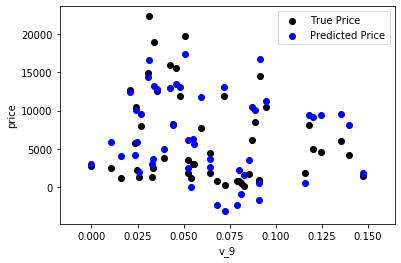

In [14]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


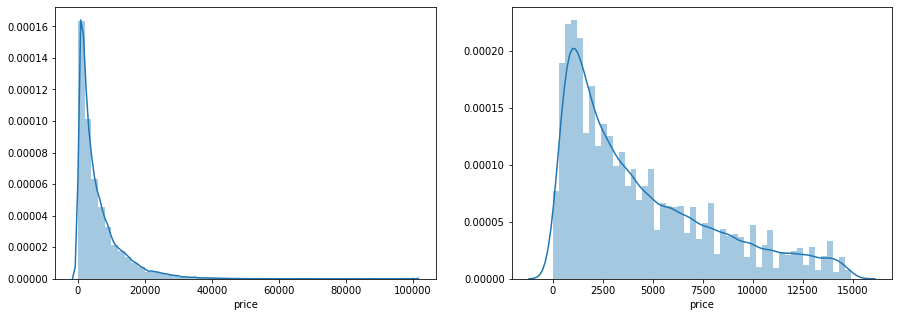

In [15]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [16]:
# 为了让数据更趋近于正态分布
train_y_ln = np.log(train_y+1)

The transformed price seems like normal distribution


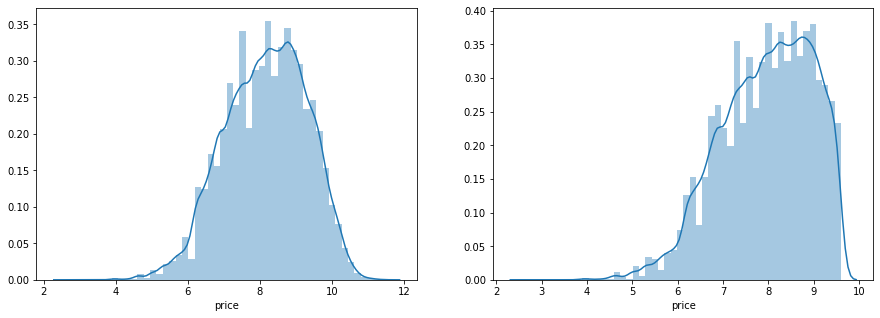

In [17]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [18]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.75074546006942


[('v_9', 8.052411927762863),
 ('v_5', 5.764248502287593),
 ('v_12', 1.6182066744720527),
 ('v_1', 1.4798302934421588),
 ('v_11', 1.1669014496953543),
 ('v_13', 0.9404706038650167),
 ('v_7', 0.7137295307923565),
 ('v_3', 0.6837865320347524),
 ('v_0', 0.008500525238604312),
 ('power_bin', 0.008497967226211652),
 ('gearbox', 0.00792237781994238),
 ('fuelType', 0.006684768278651775),
 ('bodyType', 0.0045235206591412004),
 ('power', 0.0007161896117536931),
 ('brand_price_min', 3.334353082749265e-05),
 ('brand_amount', 2.897880010254059e-06),
 ('brand_price_median', 1.257111999666447e-06),
 ('brand_price_std', 6.659134278556754e-07),
 ('brand_price_max', 6.194957240892375e-07),
 ('brand_price_average', 5.999429489134858e-07),
 ('SaleID', 2.1194162066550257e-08),
 ('seller', 1.624300693947589e-10),
 ('offerType', 1.1002043720509391e-10),
 ('train', 6.87805368215777e-12),
 ('brand_price_sum', -1.5126510445812127e-10),
 ('name', -7.015510649930789e-08),
 ('used_time', -4.122477171058066e-06),
 

The predicted price seems normal after np.log transforming


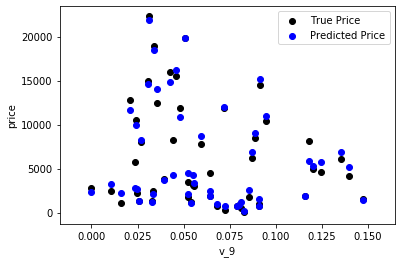

In [19]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [21]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [22]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [23]:
print ("AVG:", np.mean(scores))

AVG: 1.3658024042407695


In [24]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [25]:
print ("AVG:", np.mean(scores))

AVG: 0.19325301535176886


In [26]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [27]:
# 模拟真实的业务情况(不能采用5折的方式,需要采用时间分隔因为有时间加入进来)
import datetime

In [28]:
sample_feature = sample_feature.reset_index(drop=True)

In [41]:
#但//取的是结果的最小整数，而/取得是实际的除法结果，这就是二者的主要区别啦
split_point = len(sample_feature) // 5 * 4

In [42]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [36]:
model = model.fit(train_X, train_y_ln)

In [43]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19584113520012916

In [44]:
from sklearn.model_selection import learning_curve, validation_curve

In [45]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt 

<module 'matplotlib.pyplot' from 'C:\\Users\\wd\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

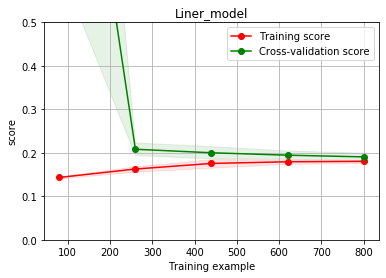

In [46]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [47]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [49]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [50]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [51]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.75072076537659


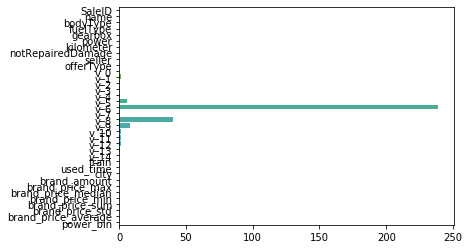

In [52]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.6717108561461655


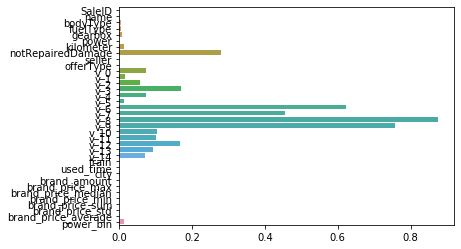

In [53]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182455497687


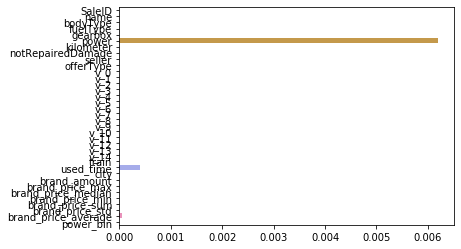

In [54]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

In [55]:
# 非线性模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [61]:
#models = [LinearRegression(),
#          DecisionTreeRegressor(),
#          RandomForestRegressor(n_estimators=100),
#          GradientBoostingRegressor(),
#          MLPRegressor(solver='lbfgs', max_iter=100), 
#          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
#          LGBMRegressor(n_estimators = 100)]

In [64]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [65]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [66]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.196776,177.765109,0.142378,0.141544
cv2,0.193758,0.192342,627.931583,0.140922,0.145501
cv3,0.194132,0.190847,187.434407,0.139393,0.143887
cv4,0.191825,0.188366,321.460805,0.137492,0.142497
cv5,0.195758,0.203395,655.549655,0.143733,0.144852


In [69]:
# 调参
from sklearn.model_selection import GridSearchCV

In [70]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [71]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

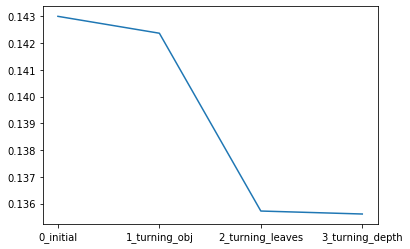

In [72]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [73]:
from sklearn.model_selection import GridSearchCV
# 机器性能有限,没办法调参

In [74]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

KeyboardInterrupt: 

In [ ]:
clf.best_params_

In [ ]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [ ]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))